
# Titanic — Abordagem com **Grafos** (Graph Features + Propagação de Rótulos)

Neste notebook, modelamos relações entre passageiros como um **grafo** e usamos isso para melhorar as previsões:
- **Nós**: passageiros (train + test).
- **Arestas**: conexões fortes (mesmo `Ticket`, mesma **família** via `Surname`, mesma `CabinDeck`), formando grupos.
- **Features de grafo**: `degree`, `weighted_degree`, `clustering`, `pagerank`, `component_size`.
- **Propagação de rótulos (semi-supervisionado)**: calculamos um **prior de sobrevivência por componente** usando apenas rótulos do train e o propagamos para todos os nós do componente (sem vazamento).
- Combinamos features tabulares + features de grafo e treinamos um classificador com validação cruzada.

> Coloque `train.csv` e `test.csv` em `./data`.


## 1) Imports e setup

In [1]:

import os
import numpy as np
import pandas as pd

import networkx as nx

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

DATA_DIR = ""
train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")


## 2) Carregar e preparar identificadores de grupo

In [2]:

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

# Anexamos uma flag para diferenciar
train["_is_train"] = 1
test["_is_train"]  = 0

# Construímos campos úteis para agrupamentos/arestas
def add_group_fields(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Sobrenome a partir de Name
    out["Surname"] = out["Name"].str.extract(r"^(.*?),")
    # Família mais robusta: Surname + Ticket root (sem espaços)
    ticket_root = out["Ticket"].astype(str).str.replace(r"\\s+", "", regex=True)
    out["FamilyID"] = (out["Surname"].fillna("") + "_" + ticket_root)
    # Deck principal
    out["CabinDeck"] = out["Cabin"].astype(str).str[0]
    out.loc[out["Cabin"].isna(), "CabinDeck"] = "U"
    return out

train = add_group_fields(train)
test  = add_group_fields(test)

full = pd.concat([train, test], ignore_index=True, sort=False)
full.shape, train.shape, test.shape


((1309, 16), (891, 16), (418, 15))

## 3) Construir o grafo de passageiros

In [3]:

G = nx.Graph()

# Adiciona todos os nós (inclui train e test)
for _, row in full.iterrows():
    pid = int(row["PassengerId"])
    G.add_node(pid, is_train=int(row["_is_train"]))

# Arestas por Ticket (fortíssima)
for ticket, idx in full.groupby("Ticket").indices.items():
    ids = full.loc[idx, "PassengerId"].astype(int).tolist()
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            G.add_edge(ids[i], ids[j], w=3.0, kind="ticket")

# Arestas por FamilyID (família/sobrenome + ticket root)
for fid, idx in full.groupby("FamilyID").indices.items():
    ids = full.loc[idx, "PassengerId"].astype(int).tolist()
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            G.add_edge(ids[i], ids[j], w=2.0, kind="family")

# Arestas por CabinDeck (vizinhança física mais fraca)
for deck, idx in full.groupby("CabinDeck").indices.items():
    ids = full.loc[idx, "PassengerId"].astype(int).tolist()
    for i in range(len(ids)-1):
        G.add_edge(ids[i], ids[i+1], w=0.5, kind="deck")

n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
n_nodes, n_edges


(1309, 2009)

## 4) Features de grafo por passageiro

In [4]:

# Degree simples e ponderado (usando atributo 'w' das arestas)
deg = dict(G.degree())
wdeg = dict(G.degree(weight="w"))
clust = nx.clustering(G, weight=None)
pr = nx.pagerank(G, alpha=0.85, weight="w")

# Componentes conectados
comp_id = {}
comp_size = {}
for cid, comp in enumerate(nx.connected_components(G)):
    size = len(comp)
    for node in comp:
        comp_id[node] = cid
        comp_size[node] = size

graph_feats = pd.DataFrame({
    "PassengerId": list(G.nodes()),
    "g_degree": [deg[n] for n in G.nodes()],
    "g_wdegree": [wdeg[n] for n in G.nodes()],
    "g_clustering": [clust.get(n, 0.0) for n in G.nodes()],
    "g_pagerank": [pr[n] for n in G.nodes()],
    "g_component_size": [comp_size[n] for n in G.nodes()],
    "g_component_id": [comp_id[n] for n in G.nodes()],
})
graph_feats.head()


,PassengerId,g_degree,g_wdegree,g_clustering,g_pagerank,g_component_size,g_component_id
0,1,1,0.5,0.0,0.000433,1257,0
1,2,2,2.5,0.0,0.000560,1257,0
2,3,2,1.0,0.0,0.000752,1257,0
3,4,3,3.0,0.0,0.000740,1257,0
4,5,2,1.0,0.0,0.000624,1257,0


## 5) Propagação de rótulos (prior por componente)

In [5]:

train_labels = train.set_index("PassengerId")["Survived"]

comp_prior = {}
for cid, comp in enumerate(nx.connected_components(G)):
    comp_nodes = list(comp)
    comp_train = [n for n in comp_nodes if G.nodes[n]["is_train"] == 1]
    if len(comp_train) > 0:
        y_comp = train_labels.reindex(comp_train)
        prior = y_comp.mean()
        comp_prior[cid] = float(prior)
    else:
        comp_prior[cid] = float(train_labels.mean())

graph_feats["g_prior_comp"] = graph_feats["g_component_id"].map(comp_prior).astype(float)
graph_feats.head()


,PassengerId,g_degree,g_wdegree,g_clustering,g_pagerank,g_component_size,g_component_id,g_prior_comp
0,1,1,0.5,0.0,0.000433,1257,0,0.369285
1,2,2,2.5,0.0,0.000560,1257,0,0.369285
2,3,2,1.0,0.0,0.000752,1257,0,0.369285
3,4,3,3.0,0.0,0.000740,1257,0,0.369285
4,5,2,1.0,0.0,0.000624,1257,0,0.369285


## 6) Montar dataset final (tabular + grafo)

In [6]:

full2 = full.merge(graph_feats, on="PassengerId", how="left")

FEATURES_NUM = ["Age", "SibSp", "Parch", "Fare",
                "g_degree", "g_wdegree", "g_clustering", "g_pagerank",
                "g_component_size", "g_prior_comp"]
FEATURES_CAT = ["Pclass", "Sex", "Embarked"]
TARGET = "Survived"

X_full = full2[FEATURES_NUM + FEATURES_CAT].copy()
y_train = train[TARGET].values

X_train = X_full[full2["_is_train"] == 1]
X_test  = X_full[full2["_is_train"] == 0]

X_train.shape, X_test.shape


((891, 13), (418, 13))

## 7) Pipeline + modelos

In [7]:

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, FEATURES_NUM),
        ("cat", categorical_pipeline, FEATURES_CAT),
    ]
)

models = {
    "LR": LogisticRegression(max_iter=1000, random_state=SEED),
    "RF": RandomForestClassifier(random_state=SEED, n_estimators=500),
    "GB": GradientBoostingClassifier(random_state=SEED)
}

pipelines = {name: Pipeline(steps=[("prep", preprocessor), ("clf", model)]) for name, model in models.items()}


## 8) Validação e escolha do modelo (AUC)

In [8]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

results = {}
for name, pipe in pipelines.items():
    auc = cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1).mean()
    results[name] = auc
    print(f"{name}: AUC (CV-5) = {auc:.4f}")

best_name = max(results, key=results.get)
best_pipe = pipelines[best_name]
print("\nMelhor modelo:", best_name)


LR: AUC (CV-5) = 0.8555
RF: AUC (CV-5) = 0.8965
GB: AUC (CV-5) = 0.8858

Melhor modelo: RF


## 9) Ajuste final, avaliação e curva ROC (treino)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       549
           1       1.00      1.00      1.00       342

    accuracy                           1.00       891
   macro avg       1.00      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891



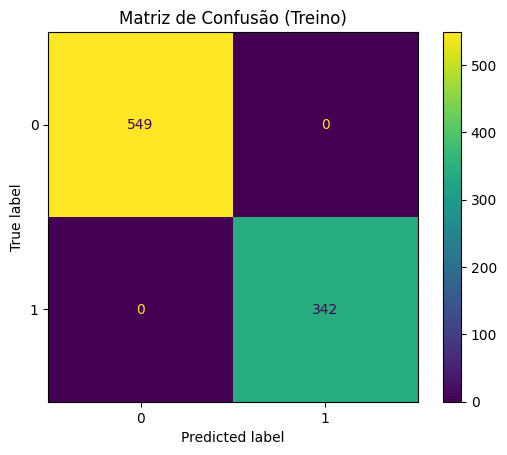

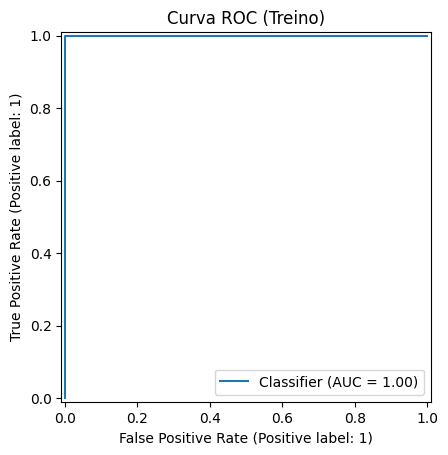

AUC (treino): 1.0


In [9]:

best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_train)
y_proba = best_pipe.predict_proba(X_train)[:, 1]

print(classification_report(y_train, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred)).plot()
plt.title("Matriz de Confusão (Treino)")
plt.show()

RocCurveDisplay.from_predictions(y_train, y_proba)
plt.title("Curva ROC (Treino)")
plt.show()

print("AUC (treino):", roc_auc_score(y_train, y_proba))


# 🚫 Vazamento de Alvo (Data Leakage) e Avaliação Incorreta

Quando analisamos modelos de Machine Learning, **avaliar no mesmo conjunto de dados usado no treino** ou incluir **informações do alvo (`y`) nas features** causa o chamado **vazamento de alvo** (*data leakage*).  
Esse problema faz com que as métricas fiquem **irrealisticamente altas**, dando a falsa impressão de um modelo perfeito.

---

## 🔍 O que aconteceu no notebook com grafos

A feature `g_prior_comp` foi criada assim:

> “média de `Survived` dentro do **componente do grafo**, usando **todas as linhas do train**.”

Isso significa que a variável já carregava **informações do próprio alvo**, pois usava o valor real de `Survived` para calcular o prior de sobrevivência.

Depois:

1. **Durante o `cross_val_score(...)`**, o modelo recebeu `X_train` contendo `g_prior_comp`, e cada fold de validação enxergou um recurso criado com **os rótulos de todo o dataset**, inclusive do próprio fold → **CV ficou otimista**.
2. **Na avaliação final**, com `best_pipe.fit(X_train, y_train)` e predição em `X_train`, o modelo foi avaliado **no mesmo conjunto em que o `prior` foi calculado**.  
   Resultado: **1.00 em tudo** — precisão, recall e F1 perfeitos.

📊 Por isso os números ficaram assim:
- `CV (otimista)` → **AUC ≈ 0.8965** no RF  
- `Treino (com vazamento)` → **Acurácia = 1.00**

---

## ✅ Como corrigir — Estratégia Out-Of-Fold (OOF)

Para eliminar o vazamento, a feature `g_prior_comp` precisa ser calculada em esquema **Out-Of-Fold (OOF)**:

1. Divida o treino em **n** folds (ex.: 5).
2. Em cada iteração:
   - Calcule o prior do componente **usando apenas os rótulos do subtreino**.
   - Aplique esse prior nos exemplos do **subvalidação**.
3. Ao final, todos os exemplos do treino terão seu `g_prior_comp_oof`, calculado **sem nunca usar seu próprio rótulo**.
4. Para o conjunto de teste:
   - Calcule o prior de cada componente **usando todos os dados de treino**.
   - Se o componente do teste não existe no treino, use a **média global**.
